In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv("pendulumData.csv")

df['sys uncert'] = df['sys uncert'].apply(lambda x: 0 if isinstance(x, str) and '+' in x else x)
df['stat uncert'] = df['stat uncert'].apply(lambda x: 0 if isinstance(x, str) and '+' in x else x)
df['total uncert'] = df['total uncert'].apply(lambda x: 0 if isinstance(x, str) and '+' in x else x)

df['sys uncert'] = pd.to_numeric(df['sys uncert']).fillna(0)
df['stat uncert'] = pd.to_numeric(df['stat uncert']).fillna(0)
df['total uncert'] = pd.to_numeric(df['total uncert']).fillna(df['stat uncert'].add(df['sys uncert']))

df = df[df['g (m/s2)'].notna()]
df = df[df['g (m/s2)'] < 100]
df = df[df['total uncert'].notna()]
print(df)

g = df['g (m/s2)'].to_numpy()
uncert = df['total uncert'].to_numpy()

mean_g = np.mean(g)
mean_uncert = np.mean(uncert)
std_g = np.std(g)
std_uncert = np.std(uncert)
print("mean g: ", mean_g)
print("mean uncert: ", mean_uncert)

               label  g (m/s2)  stat uncert  sys uncert  total uncert
0    20.Sep.X.B01.01     9.830       0.0075       0.000        0.0075
1    20.Sep.X.B01.02     9.060       0.1400       0.230        0.3700
2    20.Sep.X.B01.03     9.790       0.0200       0.020        0.0400
3    20.Sep.X.B01.04     9.882       0.0160       0.130        0.1460
5    20.Sep.X.B02.01     9.807       0.0010       0.008        0.0090
..               ...       ...          ...         ...           ...
229  23.Feb.A.B02.05    10.440       0.0000       0.000        0.3600
230  23.Feb.A.B02.06     8.500       0.0000       0.000        0.3000
231  23.Feb.A.B02.07    10.900       0.0000       0.000        1.3000
232  23.Feb.A.B02.08     9.550       0.0000       0.000        0.1300
233  23.Feb.A.B02.09    10.110       0.0000       0.000        0.2300

[233 rows x 5 columns]
mean g:  9.817732353472103
mean uncert:  0.3707510225150215


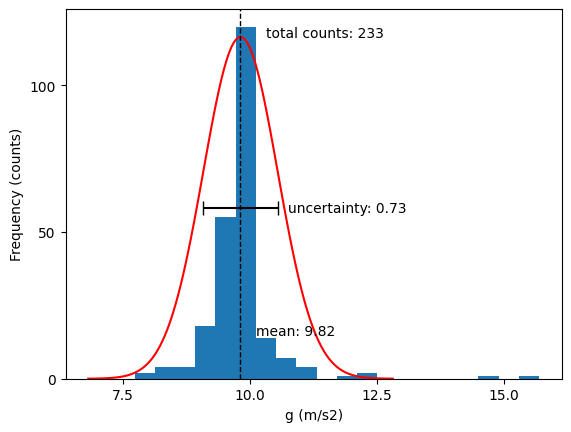

In [2]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# def lorentzian(x, mu, sig):
#     return 1 / (np.pi * sig * (1 + np.power((x - mu) / sig, 2)))

x_values = np.linspace(mean_g - 3, mean_g + 3, 120)
bin_width = 2
N = g.size / bin_width
plt.plot(x_values, N * gaussian(x_values, mean_g, std_g), color='red')
data = plt.hist(g, bins=20)

# Set axes
plt.xlabel('g (m/s2)')
plt.ylabel('Frequency (counts)')

# Annotate with mean and standard deviation
plt.annotate('mean: ' + str(round(mean_g, 2)), (mean_g + 0.3, 15), color='black')

# Annotate total counts
plt.annotate('total counts: ' + str(g.size), (mean_g + 0.5, N), color='black')

# Annotate uncertainty
plt.annotate('uncertainty: ' + str(round(std_g, 2)), (mean_g + std_g + 0.2, N / 2 - 1.5), color='black')

# Annotate the uncertainty with a horizontal error bar
plt.errorbar(mean_g, N / 2, xerr=std_g, color='black', capsize=5, capthick=1)

# Vertical line at mean
plt.axvline(mean_g, color='black', linestyle='--', linewidth=1)

# Set title
# plt.title('Measurements of g (m/s2)')

# plt.show()
# change font size
plt.rcParams.update({'font.size': 24, 'font.family': 'times new roman'})

plt.savefig('g.pdf', bbox_inches='tight')

[  2.   4.   4.  18.  55. 120.  14.   7.   4.   1.   2.   1.   1.]


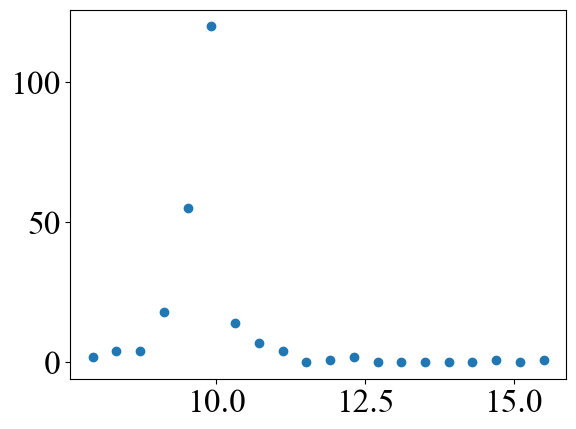

In [3]:
bin_counts = data[0]
bin_centers = []
for i in range(len(data[1]) - 1):
    bin_centers.append((data[1][i] + data[1][i + 1]) / 2)

plt.plot(bin_centers, bin_counts, 'o')

i = 0
while i < len(bin_centers):
    if bin_counts[i] == 0.0:
        bin_centers = np.delete(bin_centers, i)
        bin_counts = np.delete(bin_counts, i)
    else:
        i += 1
        
bin_uncertainties = np.sqrt(bin_counts)
bin_centers = np.array(bin_centers)
bin_counts = np.array(bin_counts)
print(bin_counts)

In [114]:
import scipy.optimize as opt
from scipy.special import factorial

def scaled_gaussian(x, mu, sig):
    return g.size / bin_width * gaussian(x, mu, sig)

FUNC_TO_FIT = scaled_gaussian

popt, pcov = opt.curve_fit(f=FUNC_TO_FIT, xdata=bin_centers, ydata=bin_counts, sigma=bin_uncertainties, p0=[9.8,0.3], absolute_sigma=True)
uncert = np.sqrt(np.diag(pcov))
print(popt, uncert)

[9.81338064 0.25886503] [0.01910796 0.01234084]


<ErrorbarContainer object of 3 artists>

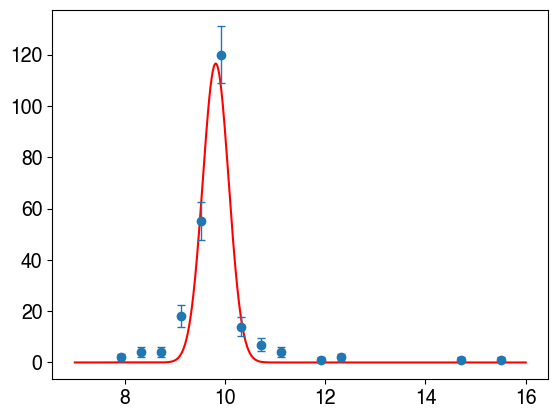

In [115]:
x = np.linspace(7, 16, 1000)
plt.plot(x, FUNC_TO_FIT(x, *popt), color='red')
plt.errorbar(bin_centers, bin_counts, yerr=bin_uncertainties, linewidth=1, ls='none', fmt='o', capsize=3)

In [127]:
from scipy import stats

def chisq(func,popt,x,y,sig):
    '''
    Inputs:
    func = function to generate expected value
    x = x data
    y = y data
    sig = sigma data
    Outputs:
    chi2 = chi-squared value
    '''
    expected_vals = func(x, *popt)
    return np.sum((y-expected_vals)**2/sig**2)

params = 2
dof = len(bin_centers) - params

# f_exp = [FUNC_TO_FIT(x, *popt) for x in bin_centers]
# f_exp_mean = np.mean(f_exp)
# f_exp = [x * np.mean(bin_counts) / f_exp_mean for x in f_exp]
# chi2 = stats.chisquare(bin_counts, f_exp, ddof=params).statistic

chi2 = chisq(FUNC_TO_FIT, popt,bin_centers, bin_counts, bin_uncertainties)
reduced_chi2 = chi2 / dof
chi2_prob = 1 - stats.chi2.cdf(chi2, dof)

print("degrees of freedom =", dof)
print("chi2 =", chi2)
print("reduced chi2 (chi2/dof) =", reduced_chi2)
print("chi2 probability", chi2_prob)
print("Best fit parameters:")
print("mean =", popt[0])
print("standard deviation =", popt[1])


degrees of freedom = 11
chi2 = 40.42799616108861
reduced chi2 (chi2/dof) = 3.6752723782807823
chi2 probability 3.0219319950841594e-05
Best fit parameters:
mean = 9.813380638060085
standard deviation = 0.25886503418069823


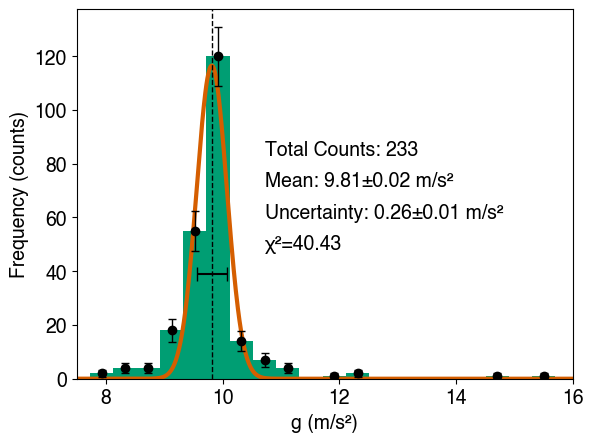

In [133]:
# Final plot
line_c = "black"
hist_c = "#009E73"
fit_c = "#D55E00"

x = np.linspace(7, 16, 1000)
plt.plot(x, FUNC_TO_FIT(x, *popt), color=fit_c, linewidth=3)
data = plt.hist(g, bins=20, color=hist_c)
plt.errorbar(bin_centers, bin_counts, yerr=bin_uncertainties, linewidth=1, ls='none', fmt='o', capsize=3, color=line_c)

leg_x = mean_g + 0.9
leg_y_top = N / 1.4
leg_y_d = N / 10.0

# Set axes
plt.xlabel('g (m/s\u00b2)')
plt.ylabel('Frequency (counts)')

# Annotate total counts
plt.annotate('Total Counts: ' + str(g.size), (leg_x, leg_y_top), color='black')

# Annotate with mean and standard deviation
plt.annotate('Mean: ' + str(round(popt[0], 2)) + "\u00b1" + str(round(uncert[0], 2)) + " m/s\u00b2", (leg_x, leg_y_top - leg_y_d), color='black')

# Annotate uncertainty
plt.annotate('Uncertainty: ' + str(round(popt[1], 2)) + "\u00b1" + str(round(uncert[1], 2)) + " m/s\u00b2", (leg_x, leg_y_top - leg_y_d*2), color='black')

# Annotate chi2 and chi2 probability
plt.annotate("\u03C7\u00b2=" + str(round(chi2, 2)), (leg_x, leg_y_top - leg_y_d*3), color="black")

# Annotate the uncertainty with a horizontal error bar
plt.errorbar(mean_g, N / 3, xerr=popt[1], color=line_c, capsize=5, capthick=1)

# Vertical line at mean
plt.axvline(mean_g, color=line_c, linestyle='--', linewidth=1)

# Set title
# plt.title('Measurements of g (m/s2)')

# change font size
plt.rcParams.update({'font.size': 14, 'font.family': 'Helvetica'})
plt.xlim(7.5, 16)

# plt.show()
plt.savefig('g.pdf', bbox_inches='tight', pad_inches=1.5)

In [31]:
import matplotlib.font_manager

for f in matplotlib.font_manager.fontManager.ttflist:
    print(f.name)

STIXNonUnicode
STIXGeneral
STIXGeneral
STIXSizeOneSym
DejaVu Sans Mono
DejaVu Sans
STIXSizeFourSym
STIXGeneral
cmss10
STIXSizeFiveSym
DejaVu Serif Display
cmb10
STIXNonUnicode
cmsy10
cmmi10
STIXSizeTwoSym
DejaVu Serif
DejaVu Sans Mono
DejaVu Serif
STIXNonUnicode
STIXSizeOneSym
cmr10
STIXSizeTwoSym
DejaVu Sans Mono
DejaVu Sans
DejaVu Sans
DejaVu Serif
STIXSizeThreeSym
DejaVu Sans Mono
STIXSizeFourSym
STIXGeneral
DejaVu Sans Display
DejaVu Sans
cmex10
cmtt10
STIXNonUnicode
DejaVu Serif
STIXSizeThreeSym
Kefa
Lao Sangam MN
Plantagenet Cherokee
Noto Nastaliq Urdu
Farisi
STIXIntegralsUpSm
Noto Sans Thaana
STIXSizeTwoSym
Herculanum
Bradley Hand
Arial Hebrew
Noto Sans Glagolitic
Bodoni 72 Smallcaps
Avenir Next
Telugu MN
Hiragino Sans
Tamil MN
Sathu
STIXIntegralsD
Noto Sans Marchen
Noto Sans Mandaic
Hiragino Sans GB
Noto Sans Old Italic
DIN Condensed
Georgia
Diwan Kufi
Iowan Old Style
Hoefler Text
Noto Serif Ahom
Times New Roman
Noto Sans Inscriptional Pahlavi
.New York
Verdana
Noto Sans Chakma